# Synthetic VNF Data

Gen synth data and fit multiple models agains it

In [9]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import KFold, train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

%matplotlib inline

sns.set(font_scale=1.2)
sns.set_style("white")

In [3]:
# define column names
cpu_col = 'Resource req. [e.g., CPU]'
thr_col = 'Traffic load [e.g., Mbit/s]'

In [4]:
# generate synthetic data
def gen_benchmark(cpu, coeff1=1, coeff2=1):
    """Generate max throughput for given CPU time according to log function"""
    return coeff1 * math.log2(1 + coeff2 * cpu)

def synthetic_benchmark():
    """Generate synthetic benchmark results for CPU time 0-100%"""
    cpu_list = np.arange(0.1, 1, .01)
    data = []
    for cpu in cpu_list:
        data.append([cpu, gen_benchmark(cpu, coeff2=100)])
    return pd.DataFrame(data, columns=[cpu_col, thr_col])

# inverse function to calculate cpu given a throughput
def inverse(thru, coeff2=1):
    return (1/coeff2) * (2**thru - 1)

In [5]:
# process data
df = synthetic_benchmark()
X = df[[thr_col]]
y = df[cpu_col]
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaler.fit(X)
# X_scaled = scaler.transform(X)

In [11]:
def cross_validation_rmse(model, X, y, k=5, save_model=False):
    """Do k-fold CV and return the avg RMSE on the validation set. Train and save the model."""
    scores = cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=k)
    rmse = np.sqrt(-scores)
    name = type(model).__name__
    print(f"CV RMSE of {name}: {rmse.mean()} (+/-{rmse.std()})")  
    if save_model:
        model.fit(X, y)
        joblib.dump(model, f'ml_models/synth_data/{name}.joblib')
    return rmse 

def barplot_rmse(scores, labels, data_name):
    """bar plot comparing the RMSE of the different algorithms"""
    assert len(scores) == len(labels)
    
    # preparation
    rmse_mean = [s.mean() for s in scores]
    rmse_std = [s.std() for s in scores]
    x = np.arange(len(labels))

    # plot
    fig, ax = plt.subplots()
    plt.bar(x, rmse_mean, color='grey', yerr=rmse_std, capsize=5)

    # labels
    ax.set_xlabel('Machine learning models')
    ax.set_ylabel('RMSE')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    
    fig.savefig(f'plots/{data_name}_rmse.pdf', bbox_inches='tight')

CV RMSE of LinearRegression: 0.12121162713679334 (+/-0.0834142420571489)
CV RMSE of Ridge: 0.1157083036553567 (+/-0.07204672163128789)
CV RMSE of SVR: 0.15772899390054107 (+/-0.08774146778153001)
CV RMSE of RandomForestRegressor: 0.07805895964923279 (+/-0.027179014302940296)
CV RMSE of GradientBoostingRegressor: 0.07805364007331642 (+/-0.025433426403506574)
CV RMSE of MLPRegressor: 0.16670438929384174 (+/-0.0991695183429542)


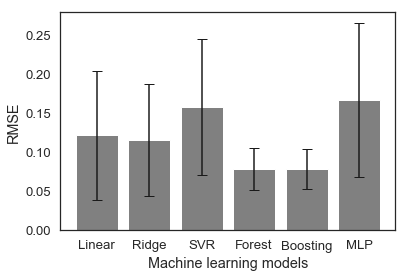

In [12]:
models = [LinearRegression(), Ridge(), SVR(), RandomForestRegressor(), 
          GradientBoostingRegressor(), MLPRegressor()]
labels = ['Linear', 'Ridge', 'SVR', 'Forest', 'Boosting', 'MLP']
rmse = [cross_validation_rmse(model, X, y) for model in models]

barplot_rmse(rmse, labels, 'synth')